# Import Lib

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import warnings
import nltk 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score,recall_score, accuracy_score, make_scorer, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from pandarallel import pandarallel
from os import walk
from wordcloud import WordCloud, STOPWORDS
from time import time
from scipy.stats import wilcoxon
import os
import sys
from sklearn.exceptions import ConvergenceWarning
from pandas.errors import SettingWithCopyWarning

# Initialization
pandarallel.initialize(progress_bar=True)

# disable unuseful warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=SettingWithCopyWarning)
os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::RuntimeWarning')


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Import Data

In [46]:
# Read the urls database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column
urls_df.rename(columns = {'URL':'Content'}, inplace = True)

# Change label "bad" in 0 and "good" in 1
urls_df.loc[urls_df["Label"]=="bad", "Label"]= 0
urls_df.loc[urls_df["Label"]=="good", "Label"]= 1
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [47]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())

In [48]:
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    392924
0    156422
Name: Label, dtype: int64


In [49]:
# Read the emails dataset
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                
# remove all redundant data
allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

# merge it in a dataframe
hamPlusSpamData = allHamData + allSpamData

# Labels: "bad" = 0 and "good" = 1
labels = [1]*len(allHamData) + [0]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData, "Label": labels})

In [50]:
# get an overview of the data
label_counter = pd.DataFrame(emails_df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    15910
0    14584
Name: Label, dtype: int64


In [51]:
df = pd.concat([urls_df, emails_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 579840 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  579840 non-null  object
 1   Label    579840 non-null  object
dtypes: object(2)
memory usage: 13.3+ MB


In [52]:
label_counter = pd.DataFrame(df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    408834
0    171006
Name: Label, dtype: int64


In [53]:
df.sample(10)

,Content,Label
116995,frtun.com/,0
221215,news.speedtv.com/topic/Scott_Tucker,1
280560,answers.com/topic/kat-foster-actor,1
540865,edreciano.com/rss/feed/stream/,0
187981,finance.yahoo.com/news/Westinghouse-to-Maintai...,1
491488,alexrpi.tk/aldi/admin/login.php,0
69854,www.nativetechnologyinc.com/native/welcome.htm,1
278440,american-cars-for-sale.co.uk/,1
11691,promovips.webuda.com/web/,0
289285,baynews9.com/article/sports/2011/september/321...,1


### Visualization

In [54]:
bad_words = df[df.Label == 0]
good_words = df[df.Label == 1]
bad_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171006 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  171006 non-null  object
 1   Label    171006 non-null  object
dtypes: object(2)
memory usage: 3.9+ MB


In [55]:
good_words.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408834 entries, 18231 to 15909
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  408834 non-null  object
 1   Label    408834 non-null  object
dtypes: object(2)
memory usage: 9.4+ MB


In [56]:
# tokenizer good words
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
good_words['text_tokenized'] = good_words.Content.parallel_map(lambda t: tokenizer.tokenize(t))
stemmer = SnowballStemmer("english")
good_words['text_stemmed'] = good_words['text_tokenized'].parallel_map(lambda l: [stemmer.stem(word) for word in l])
good_words['text_sent'] = good_words['text_stemmed'].parallel_map(lambda l: ' '.join(l))

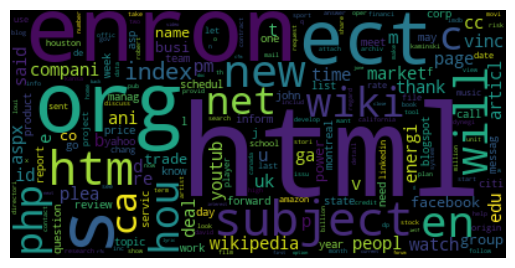

In [57]:
# Create the word cloud of good words
text = ' '.join(good_words['text_sent'].tolist())
wordcloud = WordCloud(collocations=False).generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [58]:
# tokenizer bad words
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
bad_words['text_tokenized'] = bad_words.Content.parallel_map(lambda t: tokenizer.tokenize(t))
stemmer = SnowballStemmer("english")
bad_words['text_stemmed'] = bad_words['text_tokenized'].parallel_map(lambda l: [stemmer.stem(word) for word in l])
bad_words['text_sent'] = bad_words['text_stemmed'].parallel_map(lambda l: ' '.join(l))

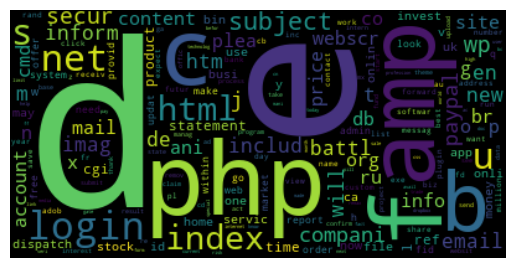

In [59]:
# Create the word cloud of bad words
text = ' '.join(bad_words['text_sent'].tolist())
wordcloud = WordCloud(collocations=False).generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Pipeline

In [60]:
stopwords = nltk.corpus.stopwords.words('english')
snow_stemmer = SnowballStemmer('english')

In [61]:
analyzer = CountVectorizer(stop_words = stopwords).build_analyzer()

In [62]:
def print_metrics(results):
    metrics = ['accuracy','precision_ham', 'recall_ham','precision_spam', 'recall_spam']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
    print()
    print(f'{"vocabulary size":15}', np.mean([len(results['estimator'][i][0].vocabulary_) for i in range(n_folds)]))
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))

### Random Undersampling

In [63]:
# Separate the majority and minority classes
majority_class = df[df['Label'] == 1]
minority_class = df[df['Label'] == 0]

# Undersample the majority class
undersampled_majority_class = majority_class.sample(n=len(minority_class), random_state=42)

# Combine the undersampled majority class with the minority class
undersampled_df = pd.concat([undersampled_majority_class, minority_class])

# Shuffle the rows of the combined dataset
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

# Reset the index
undersampled_df = undersampled_df.reset_index(drop=True)
undersampled_df.sample(10)


,Content,Label
257502,tecportais.com/ptp-users-pplp-config-cach-file...,0
292475,185.66.9.184/module/6fa68d441c87e67e6814956e01...,0
167414,oxygenconcentratorairsep.com/images/js/cp.php?...,0
194977,bigten.org/genrel/062205aab.html,1
70691,ha.com/common/auction/catalogprint.php?SaleNo=...,1
195232,www.bcgov.net/about-beaufort-county/transporta...,1
2023,hardboiled.berkeley.edu/2011/11/07/kickstarter...,1
14449,www219.paypal.co.uk.73306.ssl-120.mx/js/webapp...,0
255231,people.csail.mit.edu/jasonkb/quackle/,1
178563,martinloganmotioncouponn.blogspot.com/,1


In [64]:
undersampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342012 entries, 0 to 342011
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  342012 non-null  object
 1   Label    342012 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


In [65]:
under_label = undersampled_df.Label.values
under_label = under_label.astype('int')

# KFold cross_validate
n_folds = 10
kf = KFold(n_folds)

# LR Pipeline

Logistic Regression with TfidfVectorizer

In [66]:
start = time()
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords)), ('clf', LogisticRegression())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
LR_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score
                                      # are parallelized over the cross-validation splits.

print_metrics(LR_tfidf)

elapsed = time()-start
print(elapsed)

accuracy        0.955 [0.955, 0.955, 0.953, 0.956, 0.955, 0.955, 0.956, 0.956, 0.955, 0.956]
precision_ham   0.94 [0.94, 0.941, 0.939, 0.942, 0.939, 0.941, 0.941, 0.939, 0.941, 0.943]
recall_ham      0.972 [0.972, 0.971, 0.969, 0.973, 0.973, 0.971, 0.973, 0.973, 0.972, 0.972]
precision_spam  0.971 [0.971, 0.97, 0.968, 0.972, 0.972, 0.97, 0.972, 0.973, 0.97, 0.971]
recall_spam     0.938 [0.937, 0.938, 0.938, 0.94, 0.937, 0.939, 0.939, 0.938, 0.938, 0.941]

vocabulary size 415447.0
fit_time        60.0
score_time      1.0
228.25702047348022



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.94      0.95    171006
        Good       0.94      0.97      0.96    171006

    accuracy                           0.96    342012
   macro avg       0.96      0.96      0.96    342012
weighted avg       0.96      0.96      0.96    342012


CONFUSION MATRIX


<AxesSubplot: >

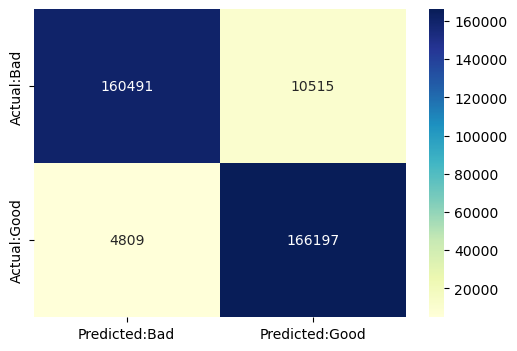

In [67]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

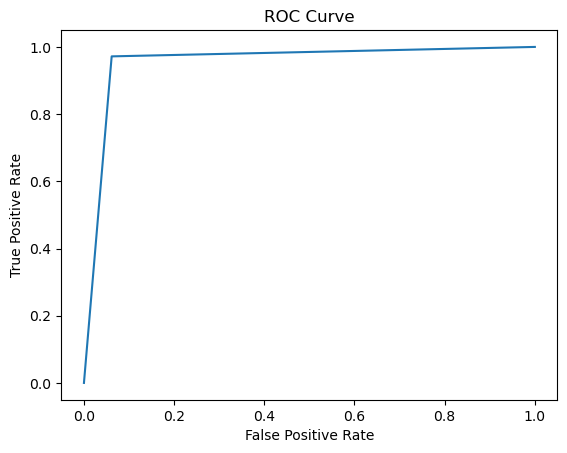

In [68]:
# Calculate the false positive rate and true positive rate
fpr_LR_tfidf, tpr_LR_tfidf, thresholds_LR_tfidf = roc_curve(under_label, y_pred)

# Calculate the ROC auc score
score_LR_tfidf = roc_auc_score(under_label, y_pred)

# Plot the ROC curve
plt.plot(fpr_LR_tfidf, tpr_LR_tfidf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

Logistic Regression with CountVectorizer

In [69]:
start = time()
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('clf', LogisticRegression())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
LR_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                         
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(LR_cvect)

elapsed = time()-start
print(elapsed)

accuracy        0.96 [0.96, 0.959, 0.958, 0.962, 0.961, 0.959, 0.96, 0.961, 0.957, 0.96]
precision_ham   0.948 [0.948, 0.948, 0.946, 0.95, 0.948, 0.948, 0.947, 0.946, 0.948, 0.95]
recall_ham      0.973 [0.973, 0.972, 0.971, 0.974, 0.975, 0.972, 0.975, 0.976, 0.967, 0.971]
precision_spam  0.972 [0.972, 0.971, 0.971, 0.974, 0.975, 0.972, 0.974, 0.976, 0.966, 0.971]
recall_spam     0.946 [0.946, 0.946, 0.946, 0.949, 0.947, 0.947, 0.945, 0.945, 0.946, 0.948]

vocabulary size 415447.0
fit_time        58.0
score_time      1.0
218.89026808738708



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.97      0.95      0.96    171006
        Good       0.95      0.97      0.96    171006

    accuracy                           0.96    342012
   macro avg       0.96      0.96      0.96    342012
weighted avg       0.96      0.96      0.96    342012


CONFUSION MATRIX


<AxesSubplot: >

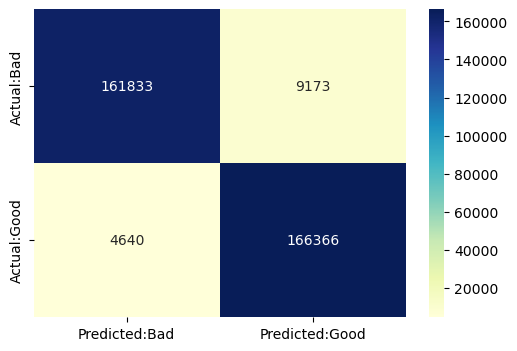

In [70]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

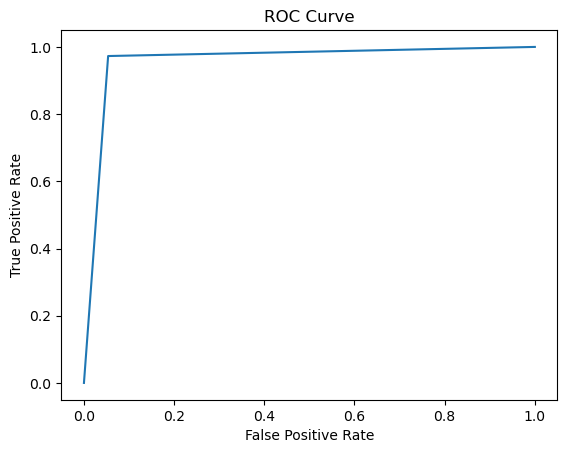

In [71]:
# Calculate the false positive rate and true positive rate
fpr_LR_cvect, tpr_LR_cvect, thresholds_LR_cvect = roc_curve(under_label, y_pred)

# Calculate the ROC auc score
score_LR_cvect = roc_auc_score(under_label, y_pred)

# Plot the ROC curve
plt.plot(fpr_LR_cvect, tpr_LR_cvect)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Comparing Metrics with different Vectorizer
We compare the accuracy metric from LogisticRegression

In [72]:
metrics = pd.DataFrame({'LR_tfidf':LR_tfidf['test_accuracy'], 'LR_cvect': LR_cvect['test_accuracy']})
metrics

,LR_tfidf,LR_cvect
0,0.954564,0.959535
1,0.954739,0.959125
2,0.953393,0.958276
3,0.956463,0.961551
4,0.954797,0.961200
5,0.955323,0.959475
6,0.955586,0.959972
7,0.955528,0.960527
8,0.954914,0.956785
9,0.956346,0.959913


array([[<AxesSubplot: title={'center': 'LR_tfidf'}>,
        <AxesSubplot: title={'center': 'LR_cvect'}>, <AxesSubplot: >]],
      dtype=object)

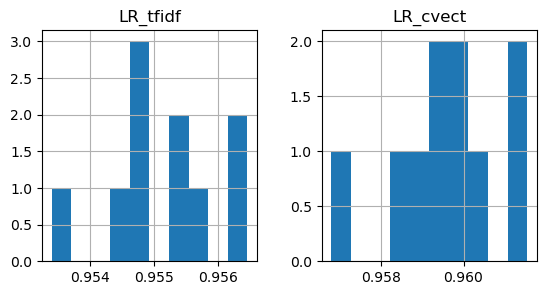

In [73]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

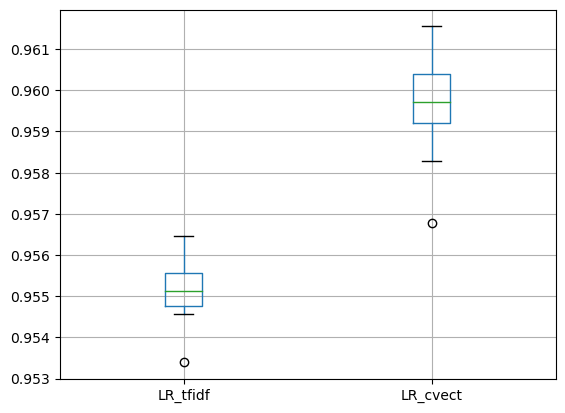

In [74]:
metrics.boxplot()

We compare the fscore_spam metric from LogisticRegression

In [75]:
metrics = pd.DataFrame({'LR_tfidf':LR_tfidf['test_fscore_spam'], 'LR_cvect': LR_cvect['test_fscore_spam']})
metrics

,LR_tfidf,LR_cvect
0,0.953406,0.958669
1,0.953882,0.958487
2,0.953090,0.958122
3,0.955739,0.961041
4,0.954141,0.960785
5,0.954629,0.958972
6,0.954884,0.959421
7,0.954999,0.960153
8,0.953783,0.956007
9,0.955490,0.959299


array([[<AxesSubplot: title={'center': 'LR_tfidf'}>,
        <AxesSubplot: title={'center': 'LR_cvect'}>, <AxesSubplot: >]],
      dtype=object)

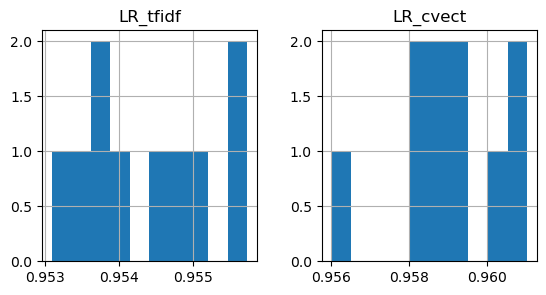

In [76]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

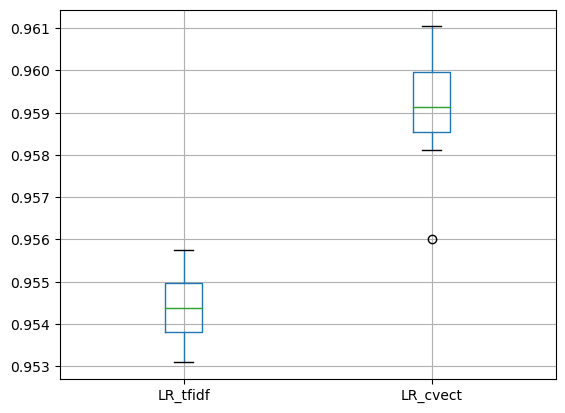

In [77]:
metrics.boxplot()

In [78]:
# We reject the null hypothesis at a confidence level of 5%,
# concluding that there is a difference in accuracy
# between the classifiers

stat,p = wilcoxon(metrics.LR_tfidf,metrics.LR_cvect)

print("Wilcoxon rank sum statistic:", stat)
print("p-value:", p)

Wilcoxon rank sum statistic: 0.0
p-value: 0.001953125


##### Compare the ROC curve of the two models

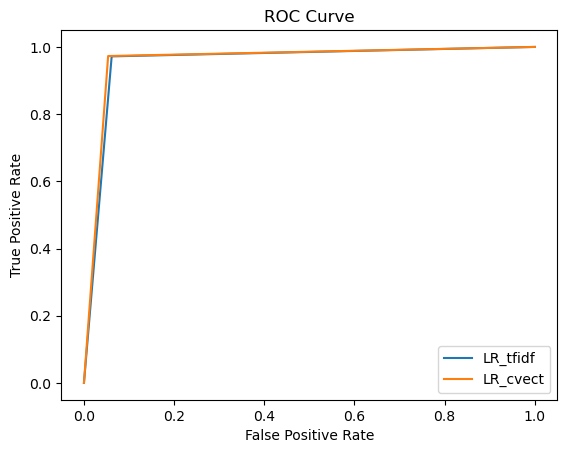

In [79]:
# Plot the ROC curves
plt.plot(fpr_LR_tfidf, tpr_LR_tfidf, label='LR_tfidf')
plt.plot(fpr_LR_cvect, tpr_LR_cvect, label='LR_cvect')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [80]:
print("ROC AUC Score of LR_tfidf:", score_LR_tfidf)
print("ROC AUC Score of LR_cvect:", score_LR_cvect)

ROC AUC Score of LR_tfidf: 0.9551945545770324
ROC AUC Score of LR_cvect: 0.9596125282153841


# SVC Pipeline

### SVC (with CountVectorizer)

In [81]:
start = time()
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('clf', LinearSVC())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
SVC_cvect = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_cvect)

elapsed = time()-start
print(elapsed)

accuracy        0.975 [0.976, 0.975, 0.975, 0.975, 0.976, 0.975, 0.976, 0.976, 0.975, 0.976]
precision_ham   0.97 [0.97, 0.971, 0.969, 0.97, 0.971, 0.971, 0.97, 0.968, 0.97, 0.972]
recall_ham      0.981 [0.982, 0.98, 0.98, 0.98, 0.981, 0.98, 0.982, 0.984, 0.981, 0.981]
precision_spam  0.981 [0.981, 0.98, 0.98, 0.98, 0.981, 0.98, 0.982, 0.984, 0.98, 0.981]
recall_spam     0.97 [0.969, 0.971, 0.969, 0.97, 0.971, 0.97, 0.969, 0.968, 0.97, 0.971]

vocabulary size 415447.0
fit_time        112.0
score_time      1.0
478.63798689842224



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.97      0.98    171006
        Good       0.97      0.98      0.98    171006

    accuracy                           0.98    342012
   macro avg       0.98      0.98      0.98    342012
weighted avg       0.98      0.98      0.98    342012


CONFUSION MATRIX


<AxesSubplot: >

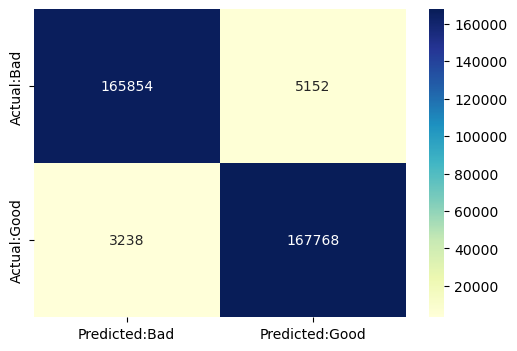

In [82]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

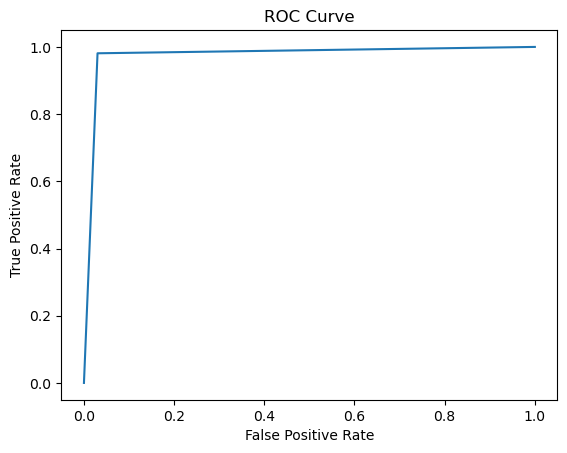

In [83]:
# Calculate the false positive rate and true positive rate
fpr_SVC_cvect, tpr_SVC_cvect, thresholds_SVC_cvect = roc_curve(under_label, y_pred)

# Calculate the ROC auc score
score_SVC_cvect = roc_auc_score(under_label, y_pred)

# Plot the ROC curve
plt.plot(fpr_SVC_cvect, tpr_SVC_cvect)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### SVC (with TfidfVectorizer)

In [84]:
start = time()
pipe = Pipeline([('vect', TfidfVectorizer(stop_words = stopwords)), ('clf', LinearSVC())])
y_pred = cross_val_predict(pipe, undersampled_df.Content.values, under_label, cv=kf)
SVC_tfidf = cross_validate(pipe,
                         undersampled_df.Content.values,
                         under_label,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVC_tfidf)

elapsed = time()-start
print(elapsed)

accuracy        0.978 [0.977, 0.977, 0.977, 0.978, 0.978, 0.978, 0.977, 0.977, 0.977, 0.978]
precision_ham   0.972 [0.971, 0.973, 0.971, 0.973, 0.973, 0.972, 0.972, 0.97, 0.972, 0.973]
recall_ham      0.983 [0.984, 0.982, 0.981, 0.983, 0.984, 0.983, 0.984, 0.985, 0.983, 0.984]
precision_spam  0.983 [0.984, 0.982, 0.982, 0.983, 0.984, 0.983, 0.984, 0.985, 0.982, 0.984]
recall_spam     0.972 [0.97, 0.972, 0.972, 0.972, 0.973, 0.972, 0.971, 0.97, 0.972, 0.973]

vocabulary size 415447.0
fit_time        24.0
score_time      2.0
131.30485558509827



CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.98      0.97      0.98    171006
        Good       0.97      0.98      0.98    171006

    accuracy                           0.98    342012
   macro avg       0.98      0.98      0.98    342012
weighted avg       0.98      0.98      0.98    342012


CONFUSION MATRIX


<AxesSubplot: >

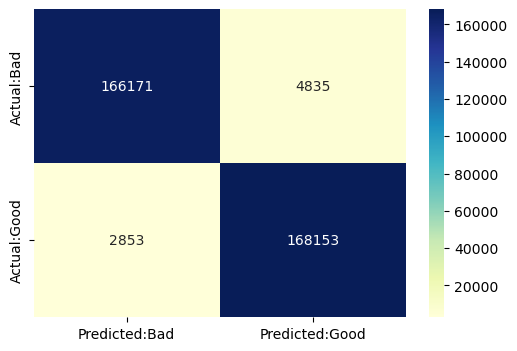

In [85]:
con_mat = pd.DataFrame(confusion_matrix(under_label, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report(under_label, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

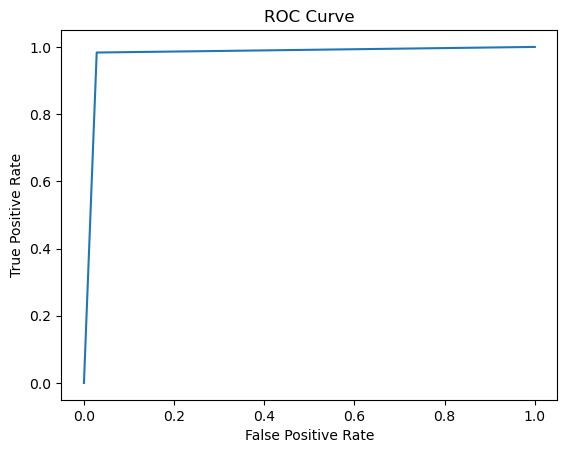

In [86]:
# Calculate the false positive rate and true positive rate
fpr_SVC_tfidf, tpr_SVC_tfidf, thresholds_SVC_tfidf = roc_curve(under_label, y_pred)

# Calculate the ROC auc score
score_SVC_tfidf = roc_auc_score(under_label, y_pred)

# Plot the ROC curve
plt.plot(fpr_SVC_tfidf, tpr_SVC_tfidf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# LR vs SVC

### Comparing Metrics with different Models
We compare the fscore_spam metrics from LogisticRegression and LinearSVC
FScore

In [87]:
metrics = pd.DataFrame({'LR':LR_cvect['test_fscore_spam'], 'SVC': SVC_cvect['test_fscore_spam']})
metrics

,LR,SVC
0,0.958669,0.975310
1,0.958487,0.975149
2,0.958122,0.974913
3,0.961041,0.974834
4,0.960785,0.975673
5,0.958972,0.975044
6,0.959421,0.975551
7,0.960153,0.975930
8,0.956007,0.974847
9,0.959299,0.976025


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

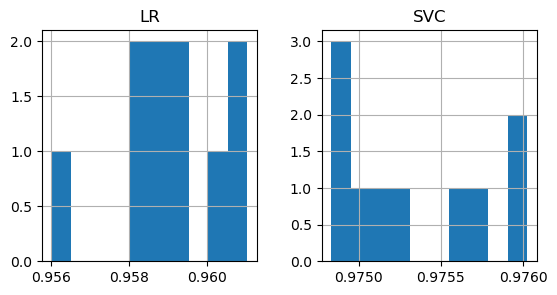

In [88]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

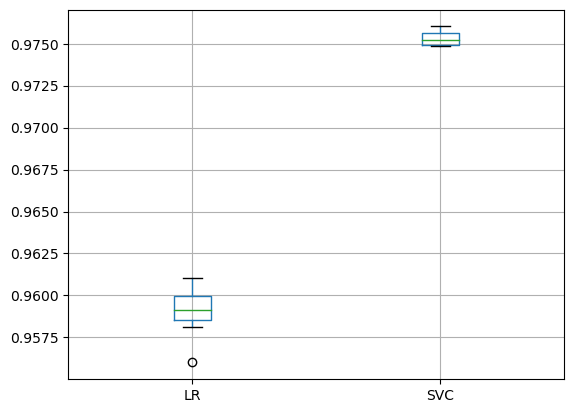

In [89]:
metrics.boxplot()

Accuracy metrics comparison 

In [90]:
metrics = pd.DataFrame({'LR':LR_cvect['test_accuracy'], 'SVC': SVC_cvect['test_accuracy']})
metrics

,LR,SVC
0,0.959535,0.975645
1,0.959125,0.975323
2,0.958276,0.974825
3,0.961551,0.974971
4,0.961200,0.975702
5,0.959475,0.975147
6,0.959972,0.975673
7,0.960527,0.975966
8,0.956785,0.975176
9,0.959913,0.976229


array([[<AxesSubplot: title={'center': 'LR'}>,
        <AxesSubplot: title={'center': 'SVC'}>, <AxesSubplot: >]],
      dtype=object)

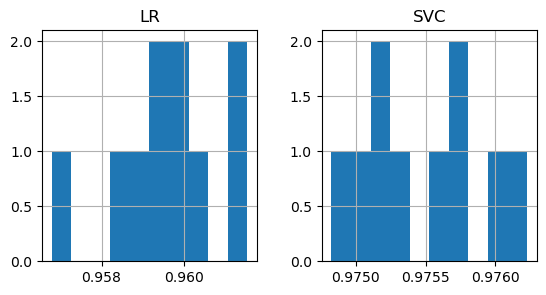

In [91]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

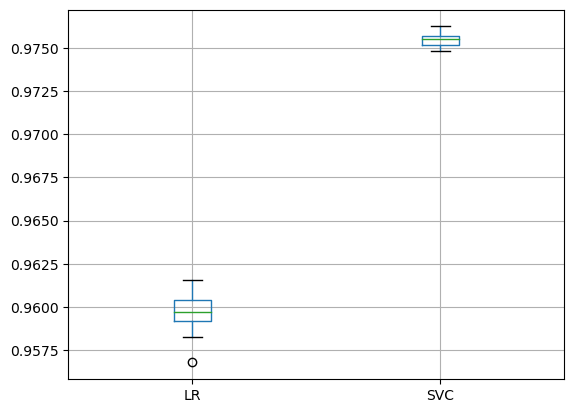

In [92]:
metrics.boxplot()

In [93]:
# We reject the null hypothesis at a confidence level of 5%,
# concluding that there is a difference in accuracy
# between the classifiers

stat,p = wilcoxon(metrics.LR,metrics.SVC)

print("Wilcoxon rank sum statistic:", stat)
print("p-value:", p)

Wilcoxon rank sum statistic: 0.0
p-value: 0.001953125


##### Compare the ROC curve of the two models

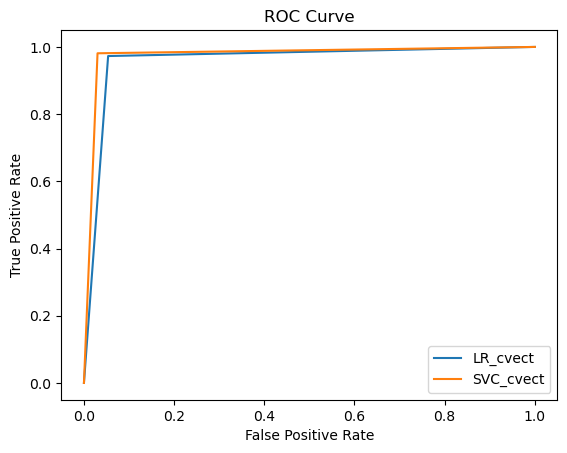

In [94]:
# Plot the ROC curves
plt.plot(fpr_LR_cvect, tpr_LR_cvect, label='LR_cvect')
plt.plot(fpr_SVC_cvect, tpr_SVC_cvect, label='SVC_cvect')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [95]:
print("ROC AUC Score of LR_cvect:", score_LR_cvect)
print("ROC AUC Score of SVC_cvect:", score_SVC_cvect)

ROC AUC Score of LR_cvect: 0.9596125282153841
ROC AUC Score of SVC_cvect: 0.9754686970047834


### SVC with Different Vectorizer: 
#### Counter vs Tfidf

Fscore metrics comparison

In [96]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_fscore_spam'], 'SVC_tfidf': SVC_tfidf['test_fscore_spam']})
metrics

,SVC_cvect,SVC_tfidf
0,0.975310,0.976990
1,0.975149,0.977055
2,0.974913,0.976616
3,0.974834,0.977537
4,0.975673,0.978356
5,0.975044,0.977466
6,0.975551,0.977378
7,0.975930,0.977305
8,0.974847,0.976981
9,0.976025,0.978219


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

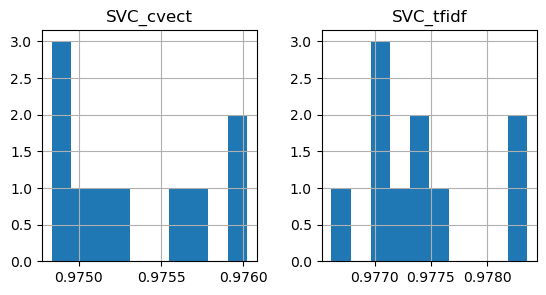

In [97]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

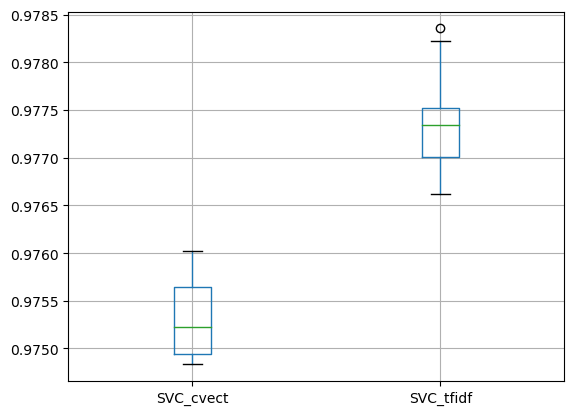

In [98]:
metrics.boxplot()

Accuracy metrics comparison

In [99]:
metrics = pd.DataFrame({'SVC_cvect':SVC_cvect['test_accuracy'], 'SVC_tfidf': SVC_tfidf['test_accuracy']})
metrics

,SVC_cvect,SVC_tfidf
0,0.975645,0.977311
1,0.975323,0.977224
2,0.974825,0.976521
3,0.974971,0.977661
4,0.975702,0.978392
5,0.975147,0.977574
6,0.975673,0.977486
7,0.975966,0.977340
8,0.975176,0.977281
9,0.976229,0.978422


array([[<AxesSubplot: title={'center': 'SVC_cvect'}>,
        <AxesSubplot: title={'center': 'SVC_tfidf'}>, <AxesSubplot: >]],
      dtype=object)

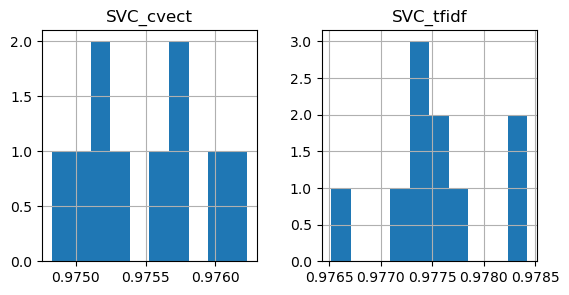

In [100]:
metrics.hist(layout = (1,3),figsize = (10,3))

<AxesSubplot: >

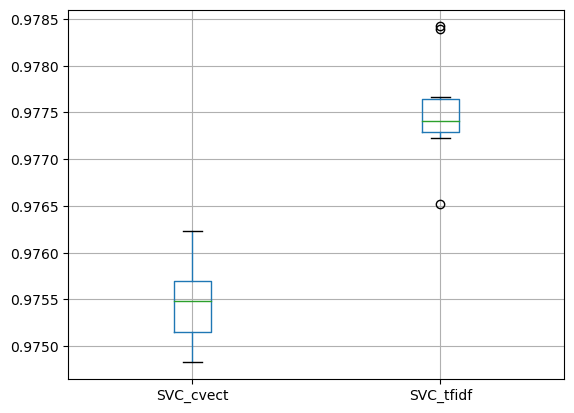

In [101]:
metrics.boxplot()

In [102]:
# We reject the null hypothesis at a confidence level of 5%,
# concluding that there is a difference in accuracy
# between the classifiers

stat,p = wilcoxon(metrics.SVC_cvect,metrics.SVC_tfidf)

print("Wilcoxon rank sum statistic:", stat)
print("p-value:", p)

Wilcoxon rank sum statistic: 0.0
p-value: 0.001953125


##### Compare the ROC curve of the two models

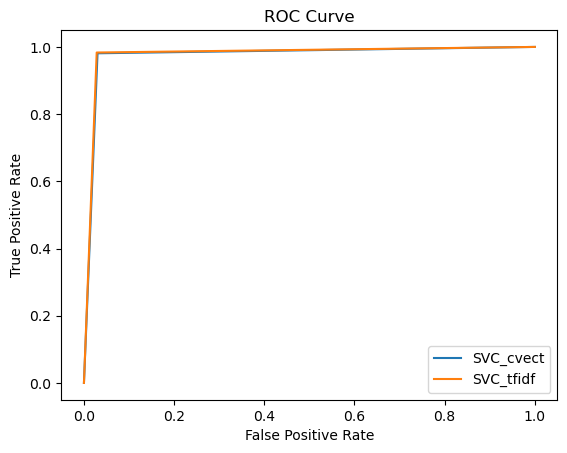

In [103]:
# Plot the ROC curves
plt.plot(fpr_SVC_cvect, tpr_SVC_cvect, label='SVC_cvect')
plt.plot(fpr_SVC_tfidf, tpr_SVC_tfidf, label='SVC_tfidf')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [104]:
print("ROC AUC Score of SVC_cvect:", score_SVC_cvect)
print("ROC AUC Score of SVC_tfidf:", score_SVC_tfidf)

ROC AUC Score of SVC_cvect: 0.9754686970047834
ROC AUC Score of SVC_tfidf: 0.9775212565640972
